In [1]:
# install python-metar
# git clone https://github.com/python-metar/python-metar
# cd python-metar
# python setup.py install

# ? https://www.openwindmap.org/
# ? https://www.blitzortung.org
# ? https://publicwiki.meteo.fr/download/attachments/12650095/Pr%C3%A9sentation%20CSM%20-%20Observation%20participative.pdf?version=1&modificationDate=1495535265741&api=v2
# ? https://caspa.sciencesconf.org/data/0204.pdf
# ? https://www.weatherlink.com


## Imports

In [1]:
#from __future__ import print_function
#
#import os
#import sys
#import getopt
#import string
import pandas as pd
import geopandas as gpd
import requests
import plotly.express as px
import traceback
#
#try:
#    from urllib2 import urlopen
#except:
#    from urllib.request import urlopen
from metar import Metar
from urllib.request import urlopen
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import datetime
import numpy as np

## Zone d'étude

In [2]:
# délimitation de l'extent dans lequel on veut récupérer les données
# encadrement large du Maroc sans Sahara Occidental
lat_ne = 36.0
lon_ne = 0.8
lat_sw = 26.5
lon_sw = -15.1

In [3]:
df_measures_cycle = pd.DataFrame()

## Récupération des données METAR

In [4]:
# on liste les aéroports dans les limites de l'extent
# basé sur https://ourairports.com/data/, documentation à https://ourairports.com/help/data-dictionary.html
URL = "https://davidmegginson.github.io/ourairports-data/airports.csv"
response = requests.get(URL)
open("./data/airports.csv", "wb").write(response.content)

df_airports = pd.read_csv('./data/airports.csv')
df_airports = gpd.GeoDataFrame(df_airports, geometry=gpd.points_from_xy(df_airports.longitude_deg, df_airports.latitude_deg))
df_airports.crs = 'epsg:4326'

condition = (df_airports["latitude_deg"]>lat_sw) & (df_airports["latitude_deg"]<lat_ne) & (df_airports["longitude_deg"]>lon_sw) & (df_airports["longitude_deg"]<lon_ne)
df_airports_study_zone = df_airports[condition].reset_index(drop=True)

In [5]:
df_airports_study_zone.head()

id ident           type                           name  latitude_deg  \
0  2146  DA11  small_airport               Hamaguir Airport     30.879000   
1  2147  DA12  small_airport  El Abiodh Sidi Cheikh Airport     32.898499   
2  2148  DA13  small_airport              Tinfouchy Airport     28.879299   
3  2149  DA14  small_airport             Mostaganem Airport     35.904134   
4  2150  DA15  small_airport                  Saïda Airport     34.897202   

   longitude_deg  elevation_ft continent iso_country iso_region  \
0      -3.067750        2454.0        AF          DZ      DZ-08   
1       0.524694        2965.0        AF          DZ      DZ-32   
2      -5.822900        1804.0        AF          DZ      DZ-37   
3       0.143337         732.0        AF          DZ      DZ-27   
4       0.151694        2444.0        AF          DZ      DZ-20   

            municipality scheduled_service gps_code iata_code local_code  \
0               Hamaguir                no     DA11       NaN       DA11   
1  El Abiodh Sidi Cheikh                no     DA12       NaN       DA12   
2           Oum El Assel                no     DA13       NaN       DA13   
3             Mostaganem                no     DA14       MQV       DA14   
4           Ouled Khaled                no     DA15       NaN       DA15   

  home_link                                    wikipedia_link  \
0       NaN                                               NaN   
1       NaN                                               NaN   
2       NaN                                               NaN   
3       NaN  https://en.wikipedia.org/wiki/Mostaganem_Airport   
4       NaN                                               NaN   

            keywords                   geometry  
0                NaN  POINT (-3.06775 30.87900)  
1                NaN   POINT (0.52469 32.89850)  
2                NaN  POINT (-5.82290 28.87930)  
3  Matemore Airfield   POINT (0.14334 35.90413)  
4            Rebahia   POINT (0.15169 34.89720)

In [6]:
# on plot les aéroports concernés
fig = px.scatter_mapbox(df_airports_study_zone, lat="latitude_deg", lon="longitude_deg", hover_name="name", # hover_data=["State", "Population"],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [7]:
# on requete les METAR
stations = df_airports_study_zone["gps_code"]

BASE_URL = "http://tgftp.nws.noaa.gov/data/observations/metar/stations"
debug = False
metar_df = pd.DataFrame()

for name in stations:
    try:
        url = "%s/%s.TXT" % (BASE_URL, name)
        if debug:
            sys.stderr.write("[ " + url + " ]")
        try:
            urlh = urlopen(url)
            report = ""
            for line in urlh:
                if not isinstance(line, str):
                    line = line.decode()  # convert Python3 bytes buffer to string
                if line.startswith(name):
                    report = line.strip()
                    obs = Metar.Metar(line)
                    metar_df = metar_df.append(pd.DataFrame({"airport":obs.station_id, "time":obs.time, "temp":obs.temp},index=[0]))
                    print(obs.string())
                    break
            if not report:
                print("No data for ", name, "\n\n")
        except Metar.ParserError as exc:
            print("METAR code: ", line)
            print(string.join(exc.args, ", "), "\n")
        except:
            print("Error retrieving", name, "data", "\n")
            print(traceback.format_exc())
            

    except:
        print("Global issue with %s" % (name))
        print(traceback.format_exc())

Error retrieving DA11 data 

Traceback (most recent call last):
  File "/tmp/ipykernel_701/632724173.py", line 14, in <cell line: 8>
    urlh = urlopen(url)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 214, in urlopen
    return opener.open(url, data, timeout)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 523, in open
    response = meth(req, response)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 632, in http_response
    response = self.parent.error(
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 555, in error
    result = self._call_chain(*args)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 494, in _call_chain
    result = func(*args)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 747, in http_error_302
    return self.parent.open(new, timeout=req.timeout)
  File "/home/j

In [8]:
# on convertit la température en float
def temp_value(x):
    try:
        return x.value()
    except:
        return np.nan

metar_df["temp"] = metar_df.apply(lambda x: temp_value(x["temp"]), axis=1)
metar_df = metar_df.reset_index(drop=True)

# on formatte le dataframe metar_df_coords, on ne filtre pour conserver que les METAR de l'heure
metar_df_coords = metar_df.merge(df_airports_study_zone[["name","latitude_deg","longitude_deg", "gps_code"]], left_on='airport', right_on='gps_code')
metar_df_coords["delay_last_obs_days"] = metar_df_coords.apply(lambda x: (datetime.datetime.utcnow() - x["time"]).days, axis=1)
metar_df_coords["delay_last_obs_hours"] = metar_df_coords.apply(lambda x: (datetime.datetime.utcnow() - x["time"]).seconds//3600, axis=1)
metar_df_coords = metar_df_coords[metar_df_coords["delay_last_obs_days"]==0]
metar_df_coords = metar_df_coords[metar_df_coords["delay_last_obs_hours"]<1]
metar_df_coords = metar_df_coords.drop(columns=["delay_last_obs_days","delay_last_obs_hours"]).dropna()
metar_df_coords = metar_df_coords.rename(columns={"airport":"id"})

In [9]:
metar_df_coords

id                time  temp  \
0   DAAY 2022-06-02 08:00:00  24.0   
2   DAOF 2022-06-02 08:00:00  25.0   
3   DAOL 2022-06-02 08:00:00  25.0   
4   DAON 2022-06-02 08:30:00  25.0   
5   DAOO 2022-06-02 08:30:00  26.0   
6   DAOR 2022-06-02 08:00:00  30.0   
8   DAOV 2022-06-02 08:00:00  23.0   
9   DAUA 2022-06-02 08:00:00  34.0   
10  DAUT 2022-06-02 08:00:00  33.0   
11  GCFV 2022-06-02 08:30:00  23.0   
12  GCRR 2022-06-02 08:30:00  23.0   
13  GECE 2022-06-02 08:30:00  20.0   
14  GEML 2022-06-02 08:30:00  24.0   
15  GMAD 2022-06-02 08:30:00  22.0   
16  GMAT 2022-06-02 08:00:00  19.0   
18  GMFF 2022-06-02 08:30:00  21.0   
19  GMFK 2022-06-02 08:00:00  27.0   
20  GMFM 2022-06-02 08:00:00  20.0   
21  GMFO 2022-06-02 08:30:00  24.0   
23  GMMB 2022-06-02 08:00:00  21.0   
24  GMMC 2022-06-02 08:00:00  21.0   
25  GMMD 2022-06-02 08:00:00  20.0   
26  GMME 2022-06-02 08:30:00  19.0   
28  GMMI 2022-06-02 08:00:00  19.0   
29  GMML 2022-06-02 08:00:00  22.0   
30  GMMN 2022-06-02 08:30:00  20.0   
32  GMMW 2022-06-02 08:00:00  23.0   
33  GMMX 2022-06-02 08:30:00  20.0   
35  GMMZ 2022-06-02 08:00:00  19.0   
37  GMTA 2022-06-02 08:00:00  24.0   
38  GMTN 2022-06-02 08:00:00  23.0   
39  GMTT 2022-06-02 08:30:00  21.0   
40  GMAG 2022-06-02 08:00:00  19.0   

                                          name  latitude_deg  longitude_deg  \
0                             Mecheria Airport     33.535900      -0.242353   
2                              Tindouf Airport     27.700399      -8.167100   
3                        Oran Tafraoui Airport     35.542400      -0.532278   
4             Zenata – Messali El Hadj Airport     35.016701      -1.450000   
5   Oran International Airport Ahmed Ben Bella     35.623901      -0.621183   
6       Béchar Boudghene Ben Ali Lotfi Airport     31.645700      -2.269860   
8                               Ghriss Airport     35.207699       0.147142   
9   Touat Cheikh Sidi Mohamed Belkebir Airport     27.837601      -0.186414   
10                            Timimoun Airport     29.237101       0.276033   
11                       Fuerteventura Airport     28.452700     -13.863800   
12            César Manrique-Lanzarote Airport     28.945499     -13.605200   
13                              Ceuta Heliport     35.892657      -5.306321   
14                             Melilla Airport     35.279800      -2.956260   
15                          Al Massira Airport     30.322478      -9.412003   
16                             Tan Tan Airport     28.448200     -11.161300   
18                               Saïss Airport     33.927299      -4.977960   
19                   Moulay Ali Cherif Airport     31.947500      -4.398330   
20                           Bassatine Airport     33.879101      -5.515120   
21                              Angads Airport     34.787201      -1.923990   
23                         Ben Slimane Airport     33.655399      -7.221450   
24                                Anfa Airport     33.553299      -7.661390   
25                         Beni Mellal Airport     32.401895      -6.315905   
26                          Rabat-Salé Airport     34.051498      -6.751520   
28                   Essaouira-Mogador Airport     31.397499      -9.681670   
29                            Hassan I Airport     27.151699     -13.219200   
30            Mohammed V International Airport     33.367500      -7.589970   
32                 Nador International Airport     34.988800      -3.028210   
33                              Menara Airport     31.606899      -8.036300   
35                          Ouarzazate Airport     30.939100      -6.909430   
37                   Cherif Al Idrissi Airport     35.177101      -3.839520   
38                        Saniat R'mel Airport     35.594299      -5.320020   
39                Tangier Ibn Battouta Airport     35.726898      -5.916890   
40                             Guelmim Airport     29.026699     -10.050300   

   gps_code  
0      DAAY 

In [10]:
df_measures_cycle = df_measures_cycle.append(metar_df_coords)

### Plotting METAR data from the last hour

In [11]:
import plotly.express as px

fig = px.scatter_mapbox(metar_df_coords, lat="latitude_deg", lon="longitude_deg", hover_name="name", color="temp",#hover_data=["State", "Population"],
                        color_discrete_sequence=["fuchsia"], zoom=4, height=600, size=[1]*len(metar_df_coords), size_max=10)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Récupération des données LMI TREMA

In [12]:
# https://stackoverflow.com/questions/41190989/how-do-i-install-geckodriver
# https://stackoverflow.com/questions/46809135/webdriver-exceptionprocess-unexpectedly-closed-with-status-1
# pip install webdrivermanager
# sudo apt-get install firefox
# webdrivermanager firefox --linkpath /usr/local/bin
# sudo apt install firefox-geckodriver

from selenium import webdriver
from time import sleep
from selenium.webdriver import FirefoxOptions

#import re
import cv2 
import pytesseract
#from pytesseract import Output
from matplotlib import pyplot as plt
from io import StringIO
from datetime import datetime as dt

In [13]:
# on réalise la copie d'écran de la page affichant les données
opts = FirefoxOptions()
opts.add_argument("--headless")

driver = webdriver.Firefox(options=opts)
driver.set_window_size(900, 900)
driver.get('http://trema.ucam.ac.ma/Obs_TREMA/index.html')
sleep(10)

driver.get_screenshot_as_file("./data/screenshot_LMI_TREMA.png")
driver.quit()

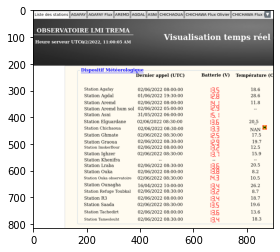

In [14]:
image = cv2.imread('./data/screenshot_LMI_TREMA.png')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.show()

In [15]:
# Get OCR output using Pytesseract
custom_config = r'--oem 3 --psm 6'
text = pytesseract.image_to_string(image, config=custom_config)
text = StringIO(text)
df_parse_lmi = pd.read_csv(text, sep="  ")

# on parse la lecture OCR
df_parse_lmi = df_parse_lmi[5:].reset_index(drop=True) # on drop les 5 premières lignes
df_parse_lmi=df_parse_lmi.rename(columns={df_parse_lmi.columns[0]:"values"}) # on renomme la colonne

for i in range(len(df_parse_lmi)) :
    try:
        df_parse_lmi.loc[i,"temp"] = float(df_parse_lmi.loc[i, "values"].split(" ")[-1])
        df_parse_lmi.loc[i,"hour"] = df_parse_lmi.loc[i, "values"].split(" ")[-2]
        df_parse_lmi.loc[i,"date"] = df_parse_lmi.loc[i, "values"].split(" ")[-3]
        df_parse_lmi.loc[i,"time"] = dt.strptime(df_parse_lmi.loc[i,"hour"]+" "+ df_parse_lmi.loc[i,"date"], "%H:%M:%S %d/%m/%Y")
        df_parse_lmi.loc[i,"station"] = ' '.join(df_parse_lmi.loc[i,"values"].split()[0:-3])
        
    except:
        print(traceback.format_exc())

df_parse_lmi = df_parse_lmi.drop(columns=["values","hour","date"]).dropna().reset_index(drop=True)


Traceback (most recent call last):
  File "/tmp/ipykernel_701/367337935.py", line 13, in <cell line: 11>
    df_parse_lmi.loc[i,"temp"] = float(df_parse_lmi.loc[i, "values"].split(" ")[-1])
ValueError: could not convert string to float: '-'

Traceback (most recent call last):
  File "/tmp/ipykernel_701/367337935.py", line 13, in <cell line: 11>
    df_parse_lmi.loc[i,"temp"] = float(df_parse_lmi.loc[i, "values"].split(" ")[-1])
ValueError: could not convert string to float: '06:00:00'

Traceback (most recent call last):
  File "/tmp/ipykernel_701/367337935.py", line 13, in <cell line: 11>
    df_parse_lmi.loc[i,"temp"] = float(df_parse_lmi.loc[i, "values"].split(" ")[-1])
ValueError: could not convert string to float: '&'

Traceback (most recent call last):
  File "/tmp/ipykernel_701/367337935.py", line 13, in <cell line: 11>
    df_parse_lmi.loc[i,"temp"] = float(df_parse_lmi.loc[i, "values"].split(" ")[-1])
ValueError: could not convert string to float: '-'



/tmp/ipykernel_701/367337935.py:5: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



In [16]:
# on corrige le doublon en virant la seconde station ouka
df_stations = pd.read_csv("./data/stations_LMI_TREMA.csv", sep=";")
df_parse_lmi = df_parse_lmi.merge(df_stations, left_on="station", right_on="station")
df_parse_lmi["name"]=df_parse_lmi["station"]

df_parse_lmi

temp                time                    station  latitude_deg  \
0   18.6 2022-06-02 08:00:00             Station Agafay     31.501453   
1   28.6 2022-06-01 19:30:00              Station Agdal     31.598568   
2   11.8 2022-06-02 08:00:00              Station Aremd     31.124616   
3   17.5 2022-06-02 08:30:00             Station Ghmate     31.422740   
4   19.7 2022-06-02 08:30:00             Station Graoua     31.584441   
5   12.5 2022-06-02 08:00:00         Station ImskerBour     31.204559   
6   15.9 2022-06-02 08:30:00             Station Ighzer     31.141792   
7   20.5 2022-06-02 08:30:00              Station Lraba     31.660892   
8    8.2 2022-06-02 08:00:00               Station Ouka     31.181801   
9   10.5 2022-06-02 08:30:00  Station Ouka observatoire     31.208730   
10  26.2 2022-04-16 10:00:00            Station Ounagha     31.440571   
11  18.7 2022-06-02 08:00:00                 Station R3     31.653208   
12  19.6 2022-06-02 08:30:00              Station Saada     31.628440   
13  13.6 2022-06-02 08:00:00          Station Tachedirt     31.155546   
14  18.3 2022-06-02 08:30:00         Station Tameslouht     31.497455   

    longitude_deg                       name  
0       -8.244994             Station Agafay  
1       -7.981433              Station Agdal  
2       -7.920203              Station Aremd  
3       -7.802908             Station Ghmate  
4       -7.916415             Station Graoua  
5       -7.939708         Station ImskerBour  
6       -8.495583             Station Ighzer  
7       -7.677483              Station Lraba  
8       -7.865382               Station Ouka  
9       -7.864469  Station Ouka observatoire  
10      -9.280904            Station Ounagha  
11      -7.604235                 Station R3  
12      -8.156659              Station Saada  
13      -7.847478          Station Tachedirt  
14      -8.094303         Station Tameslouht

In [17]:
def filter_last_cycle(df):
    df["delay_last_obs_days"] = df.apply(lambda x: (datetime.datetime.utcnow() - x["time"]).days, axis=1)
    df["delay_last_obs_hours"] = df.apply(lambda x: (datetime.datetime.utcnow() - x["time"]).seconds//3600, axis=1)
    df = df[df["delay_last_obs_days"]==0]
    df = df[df["delay_last_obs_hours"]<1]
    df = df.drop(columns=["delay_last_obs_days","delay_last_obs_hours"])
    df = df.rename(columns={"airport":"id"})
    df = df.reset_index(drop=True)
    return df

In [18]:
df_parse_lmi = filter_last_cycle(df_parse_lmi)

In [19]:
df_parse_lmi = df_parse_lmi[df_parse_lmi["temp"]<50].reset_index(drop=True)

### Plotting LMI from the last hour

In [20]:
import plotly.express as px

fig = px.scatter_mapbox(df_parse_lmi, lat="latitude_deg", lon="longitude_deg", hover_name="name", color="temp",#hover_data=["State", "Population"],
                        color_discrete_sequence=["fuchsia"], zoom=4, height=600, size=[1]*len(df_parse_lmi), size_max=10)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [21]:
df_measures_cycle = df_measures_cycle.append(df_parse_lmi)

## Récupération des données NETATMO

In [22]:
# https://trangthuyvo.wordpress.com/2019/12/03/crowdsourcing-weather-data-from-netatmo-weathermap/
#import time
#import os 
#import datetime
#from datetime import datetime   
import patatmo

In [23]:
# Define your netatmo connect developer credentials
credentials = {
    "password":"22*ljWUgzIU^",
    "username":"jeremy.lavarenne@yahoo.com",
    "client_id":    "62913128aa50e27639606fdf",
    "client_secret":"bUZWPCmEEjKW8p1ttQDWALIU5w"
    }

In [24]:
# configure the authentication
authentication = patatmo.api.authentication.Authentication(
    credentials=credentials,
    tmpfile = "temp_auth.json")

# create an api client
client = patatmo.api.client.NetatmoClient(authentication)

# lat/lon outline of Area Of Interest (Here I took NewYorkCity region)
#lat_ne = 36.0
#lon_ne = 0.8
#lat_sw = 26.5
#lon_sw = -15.1

#region = {
#        "lat_ne": 35,
#        "lat_sw": 34,
#        "lon_ne": -5,
#        "lon_sw": -8,
#        }

region = {
        "lat_ne": lat_ne,
        "lat_sw": lat_sw,
        "lon_ne": lon_ne,
        "lon_sw": lon_sw,
        }
    
# issue the API request for getting public data
netatmo = client.Getpublicdata(region = region, full=False, filter=False)

#convert the public data to pandas DataFrame
df_netatmo = netatmo.dataframe()

df_netatmo = df_netatmo.rename(columns={"latitude":"latitude_deg", "longitude":"longitude_deg", "time_temperature":"time","temperature":"temp"}).reset_index(drop=True)
df_netatmo["time"] = df_netatmo.apply(lambda x: x["time"].to_pydatetime().replace(tzinfo=None), axis=1)
df_netatmo["name"] = df_netatmo["id"]

condition = (df_netatmo["latitude_deg"]>lat_sw) & (df_netatmo["latitude_deg"]<lat_ne) & (df_netatmo["longitude_deg"]>lon_sw) & (df_netatmo["longitude_deg"]<lon_ne)
df_netatmo = df_netatmo[condition]


In [25]:
df_netatmo = filter_last_cycle(df_netatmo)

## Plotting NETATMO from the last hour

In [26]:
import plotly.express as px

fig = px.scatter_mapbox(df_netatmo, lat="latitude_deg", lon="longitude_deg", hover_name="name", color="temp", #hover_data=["State", "Population"],
                        color_discrete_sequence=["fuchsia"], zoom=4, height=600, size=[1]*len(df_netatmo), size_max=10)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [27]:
df_measures_cycle = df_measures_cycle.append(df_netatmo[["longitude_deg","latitude_deg","time","temp"]])

In [28]:
df_measures_cycle

id                time  temp  \
0   DAAY 2022-06-02 08:00:00  24.0   
2   DAOF 2022-06-02 08:00:00  25.0   
3   DAOL 2022-06-02 08:00:00  25.0   
4   DAON 2022-06-02 08:30:00  25.0   
5   DAOO 2022-06-02 08:30:00  26.0   
..   ...                 ...   ...   
21   NaN 2022-06-02 08:59:48  23.9   
22   NaN 2022-06-02 08:52:33  22.5   
23   NaN 2022-06-02 08:53:25  21.6   
24   NaN 2022-06-02 09:00:16  28.5   
25   NaN 2022-06-02 08:58:22  20.6   

                                          name  latitude_deg  longitude_deg  \
0                             Mecheria Airport     33.535900      -0.242353   
2                              Tindouf Airport     27.700399      -8.167100   
3                        Oran Tafraoui Airport     35.542400      -0.532278   
4             Zenata – Messali El Hadj Airport     35.016701      -1.450000   
5   Oran International Airport Ahmed Ben Bella     35.623901      -0.621183   
..                                         ...           ...            ...   
21                                         NaN     28.393255     -14.154336   
22                                         NaN     28.486490     -14.087565   
23                                         NaN     28.351337     -14.036267   
24                                         NaN     28.532227     -13.952581   
25                                         NaN     28.528211     -13.919323   

   gps_code station  
0      DAAY     NaN  
2      DAOF     NaN  
3      DAOL     NaN  
4      DAON     NaN  
5      DAOO     NaN  
..      ...     ...  
21      NaN     NaN  
22      NaN     NaN  
23      NaN     NaN  
24      NaN     NaN  
25      NaN     NaN  

[66 rows x 8 columns]

# global plot

In [29]:
import plotly.express as px

fig = px.scatter_mapbox(df_measures_cycle, lat="latitude_deg", lon="longitude_deg", hover_name="name", color="temp",#hover_data=["State", "Population"],
                        color_discrete_sequence=["fuchsia"], zoom=5, height=600, size=[1]*len(df_measures_cycle), size_max=15)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [30]:
gdf_measures_cycle = gpd.GeoDataFrame(df_measures_cycle.drop(columns="time"), geometry=gpd.points_from_xy(df_measures_cycle.longitude_deg, df_measures_cycle.latitude_deg))
gdf_measures_cycle.crs = 'epsg:4326'
gdf_measures_cycle.to_file("./data/gdf_measures_cycle.shp")

/tmp/ipykernel_701/1124349723.py:3: UserWarning:

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.



In [31]:
from pyidw import idw

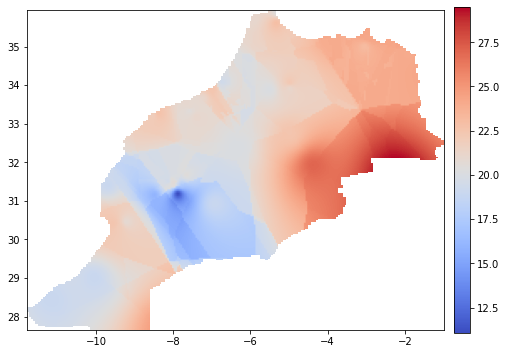

In [32]:
idw.idw_interpolation(
    input_point_shapefile="./data/gdf_measures_cycle.shp",
    extent_shapefile="./data/mar_borders/mar_admbnda_adm0_unhcr_20201203.shp",
    column_name="temp",
    power=2,
    search_radious=4,
    output_resolution=250,
)

In [33]:
from pyidw import idw
from sklearn.metrics import mean_squared_error

original_value, interpolated_value = idw.accuracy_standard_idw(
    input_point_shapefile="./data/metar_df_coords.shp",
    extent_shapefile="./data/mar_borders/mar_admbnda_adm0_unhcr_20201203.shp",
    column_name="temp",
    power=2,
    search_radious=4,
    output_resolution=250,
)

print("RMSE:", mean_squared_error(original_value, interpolated_value, squared=False))

RMSE: 6.288844155354001


In [34]:
from pyidw import idw
from sklearn.metrics import mean_squared_error

def search_best_params(power, radius) :
    try:
        original_value, interpolated_value = idw.accuracy_standard_idw(
            input_point_shapefile="./data/gdf_measures_cycle.shp",
            extent_shapefile="./data/mar_borders/mar_admbnda_adm0_unhcr_20201203.shp",
            column_name="temp",
            power=int(np.round(power,0)), #2
            search_radious=int(np.round(radius,0)), #4
            output_resolution=250
        )
        

        #print("RMSE:", mean_squared_error(original_value, interpolated_value, squared=False))

        return -mean_squared_error(original_value, interpolated_value, squared=False)
    except:
        return -9999

In [35]:
# pip install bayesian-optimization
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'power': (2, 4), 'radius': (2, len(gdf_measures_cycle))}

optimizer = BayesianOptimization(
    f=search_best_params,
    pbounds=pbounds,
    random_state=1,
)

In [36]:
optimizer.maximize(
    init_points=30,
    n_iter=30,
)

|   iter    |  target   |   power   |  radius   |
-------------------------------------------------
|  1        | -3.641    |  2.834    |  48.1     |
|  2        | -3.729    |  2.0      |  21.35    |
|  3        | -3.666    |  2.294    |  7.91     |
|  4        | -3.728    |  2.373    |  24.12    |
|  5        | -3.699    |  2.794    |  36.48    |
|  6        | -3.656    |  2.838    |  45.85    |
|  7        | -3.601    |  2.409    |  58.2     |
|  8        | -3.712    |  2.055    |  44.91    |
|  9        | -3.693    |  2.835    |  37.76    |
|  10       | -3.636    |  2.281    |  14.68    |
|  11       | -3.594    |  3.601    |  63.97    |
|  12       | -3.656    |  2.627    |  46.31    |
|  13       | -3.598    |  3.753    |  59.25    |
|  14       | -3.78     |  2.17     |  4.5      |
|  15       | -3.601    |  2.34     |  58.2     |
|  16       | -3.78     |  2.197    |  28.95    |
|  17       | -3.662    |  3.916    |  36.12    |
|  18       | -3.661    |  3.384    |  22.19    |


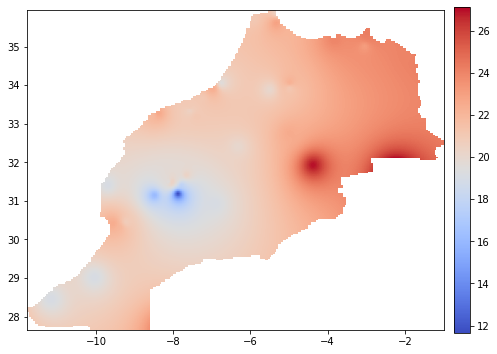

In [37]:
idw.idw_interpolation(
    input_point_shapefile="./data/gdf_measures_cycle.shp",
    extent_shapefile="./data/mar_borders/mar_admbnda_adm0_unhcr_20201203.shp",
    column_name="temp",
    power=int(np.round(optimizer.max['params']["power"],0)),
    search_radious=int(np.round(optimizer.max['params']["radius"],0)),
    output_resolution=250,
)

# Krigeage

In [38]:
import gstools as gs


bins = gs.standard_bins((gdf_measures_cycle["latitude_deg"], gdf_measures_cycle["longitude_deg"]), max_dist=np.deg2rad(8), latlon=True)
bin_c, vario = gs.vario_estimate((gdf_measures_cycle["latitude_deg"], gdf_measures_cycle["longitude_deg"]), gdf_measures_cycle["temp"], bins, latlon=True)

Spherical(latlon=True, var=5.02e+03, len_scale=2.99e+05, nugget=0.0, rescale=6.37e+03)


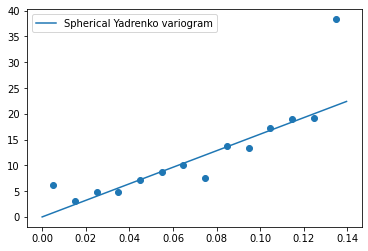

In [39]:
model = gs.Spherical(latlon=True, rescale=gs.EARTH_RADIUS)
model.fit_variogram(bin_c, vario, nugget=False)
ax = model.plot("vario_yadrenko", x_max=bins[-1])
ax.scatter(bin_c, vario)
print(model)

In [40]:
import rasterio
# read all the data from the first band
dat = rasterio.open(r'./data/DEM_MA_3.tiff')
z = dat.read()[0]

def get_elevation(lat, lon):
    idx = dat.index(lon, lat, precision=1E-6)    
    return z[idx]

In [41]:
uk = gs.krige.Universal(
    model=model,
    cond_pos=(gdf_measures_cycle["latitude_deg"], gdf_measures_cycle["longitude_deg"]),
    cond_val=gdf_measures_cycle["temp"],
    drift_functions=get_elevation
)

In [42]:
g_lat = np.arange(lat_sw, lat_ne+1, 0.1)
g_lon = np.arange(lon_sw, lon_ne, 0.1)

uk.set_pos((g_lat, g_lon), mesh_type="structured")
uk(return_var=False, store="temp_field")
uk(only_mean=True, store="mean_field")

array([[28.13695201, 28.13695201, 28.13695201, ..., 27.63766847,
        27.67061664, 27.55744029],
       [28.13695201, 28.13695201, 28.13695201, ..., 27.30498807,
        27.58261506, 27.3950709 ],
       [28.13695201, 28.13695201, 28.13695201, ..., 27.41068252,
        27.47965252, 27.31473671],
       ...,
       [28.13695201, 28.13695201, 28.13695201, ..., 28.13695201,
        28.13695201, 28.13695201],
       [28.13695201, 28.13695201, 28.13695201, ..., 28.13695201,
        28.13695201, 28.13695201],
       [28.13695201, 28.13695201, 28.13695201, ..., 28.13695201,
        28.13695201, 28.13695201]])

In [43]:
df = gpd.read_file("./data/mar_borders/mar_admbnda_adm0_unhcr_20201203.shp")  # only use the simplest polygon
border = df["geometry"].values[0]
np.savetxt("./data/mar_borders/mar_borders.txt", list(border.exterior.coords))
border = np.loadtxt("./data/mar_borders/mar_borders.txt")

min=-10
max=45

levels = np.linspace(min, max, (max-min+1))
fig, ax = plt.subplots(1, 3, figsize=[20, 8], sharey=True)
sca = ax[0].scatter(gdf_measures_cycle["longitude_deg"], gdf_measures_cycle["latitude_deg"], c=gdf_measures_cycle["temp"], vmin=min, vmax=max, cmap="nipy_spectral")
co1 = ax[1].contourf(g_lon, g_lat, uk["temp_field"], levels, cmap="nipy_spectral")
co2 = ax[2].contourf(g_lon, g_lat, uk["mean_field"], levels, cmap="nipy_spectral")




df_2 = gpd.read_file("./data/mar_borders/mar_admbnda_adm1_unhcr_20201203.shp")  # only use the simplest polygon
for j in range(len(df_2)):
    border_2 = df_2["geometry"].values[j]
    np.savetxt("./data/mar_borders/mar_borders_2.txt", list(border_2.exterior.coords))
    border_2 = np.loadtxt("./data/mar_borders/mar_borders_2.txt")
    [ax[i].plot(border_2[:, 0], border_2[:, 1], color="gray", linewidth=0.5) for i in range(3)]

[ax[i].plot(border[:, 0], border[:, 1], color="k") for i in range(3)]

#[ax[i].set_xlim([5, 16]) for i in range(3)]
[ax[i].set_xlabel("Lon in deg") for i in range(3)]
ax[0].set_ylabel("Lat in deg")

ax[0].set_title("Temperature observations at 2m\nfrom DWD (2020-06-09 12:00)")
ax[1].set_title("Interpolated temperature\nwith altitude drift")
ax[2].set_title("Estimated mean drift\nfrom Universal Kriging")

fmt = dict(orientation="horizontal", shrink=0.5, fraction=0.1, pad=0.2)
fig.colorbar(co2, ax=ax, **fmt).set_label("T in [°C]")

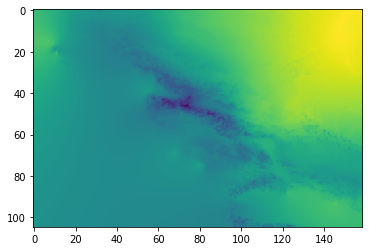

In [59]:
plt.imshow(uk["temp_field"])

In [97]:
elev = np.empty((len(g_lat), len(g_lon)), dtype=float)
for idx, a0 in enumerate(g_lat) :
    for jdx, b0 in enumerate(g_lon) :
        try:
            elev[idx, jdx] = get_elevation(a0, b0)
        except:
            pass

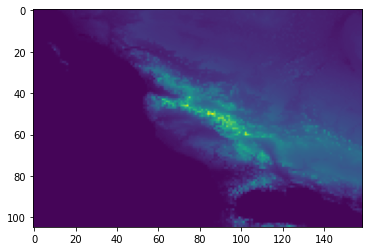

In [98]:
plt.imshow(elev)

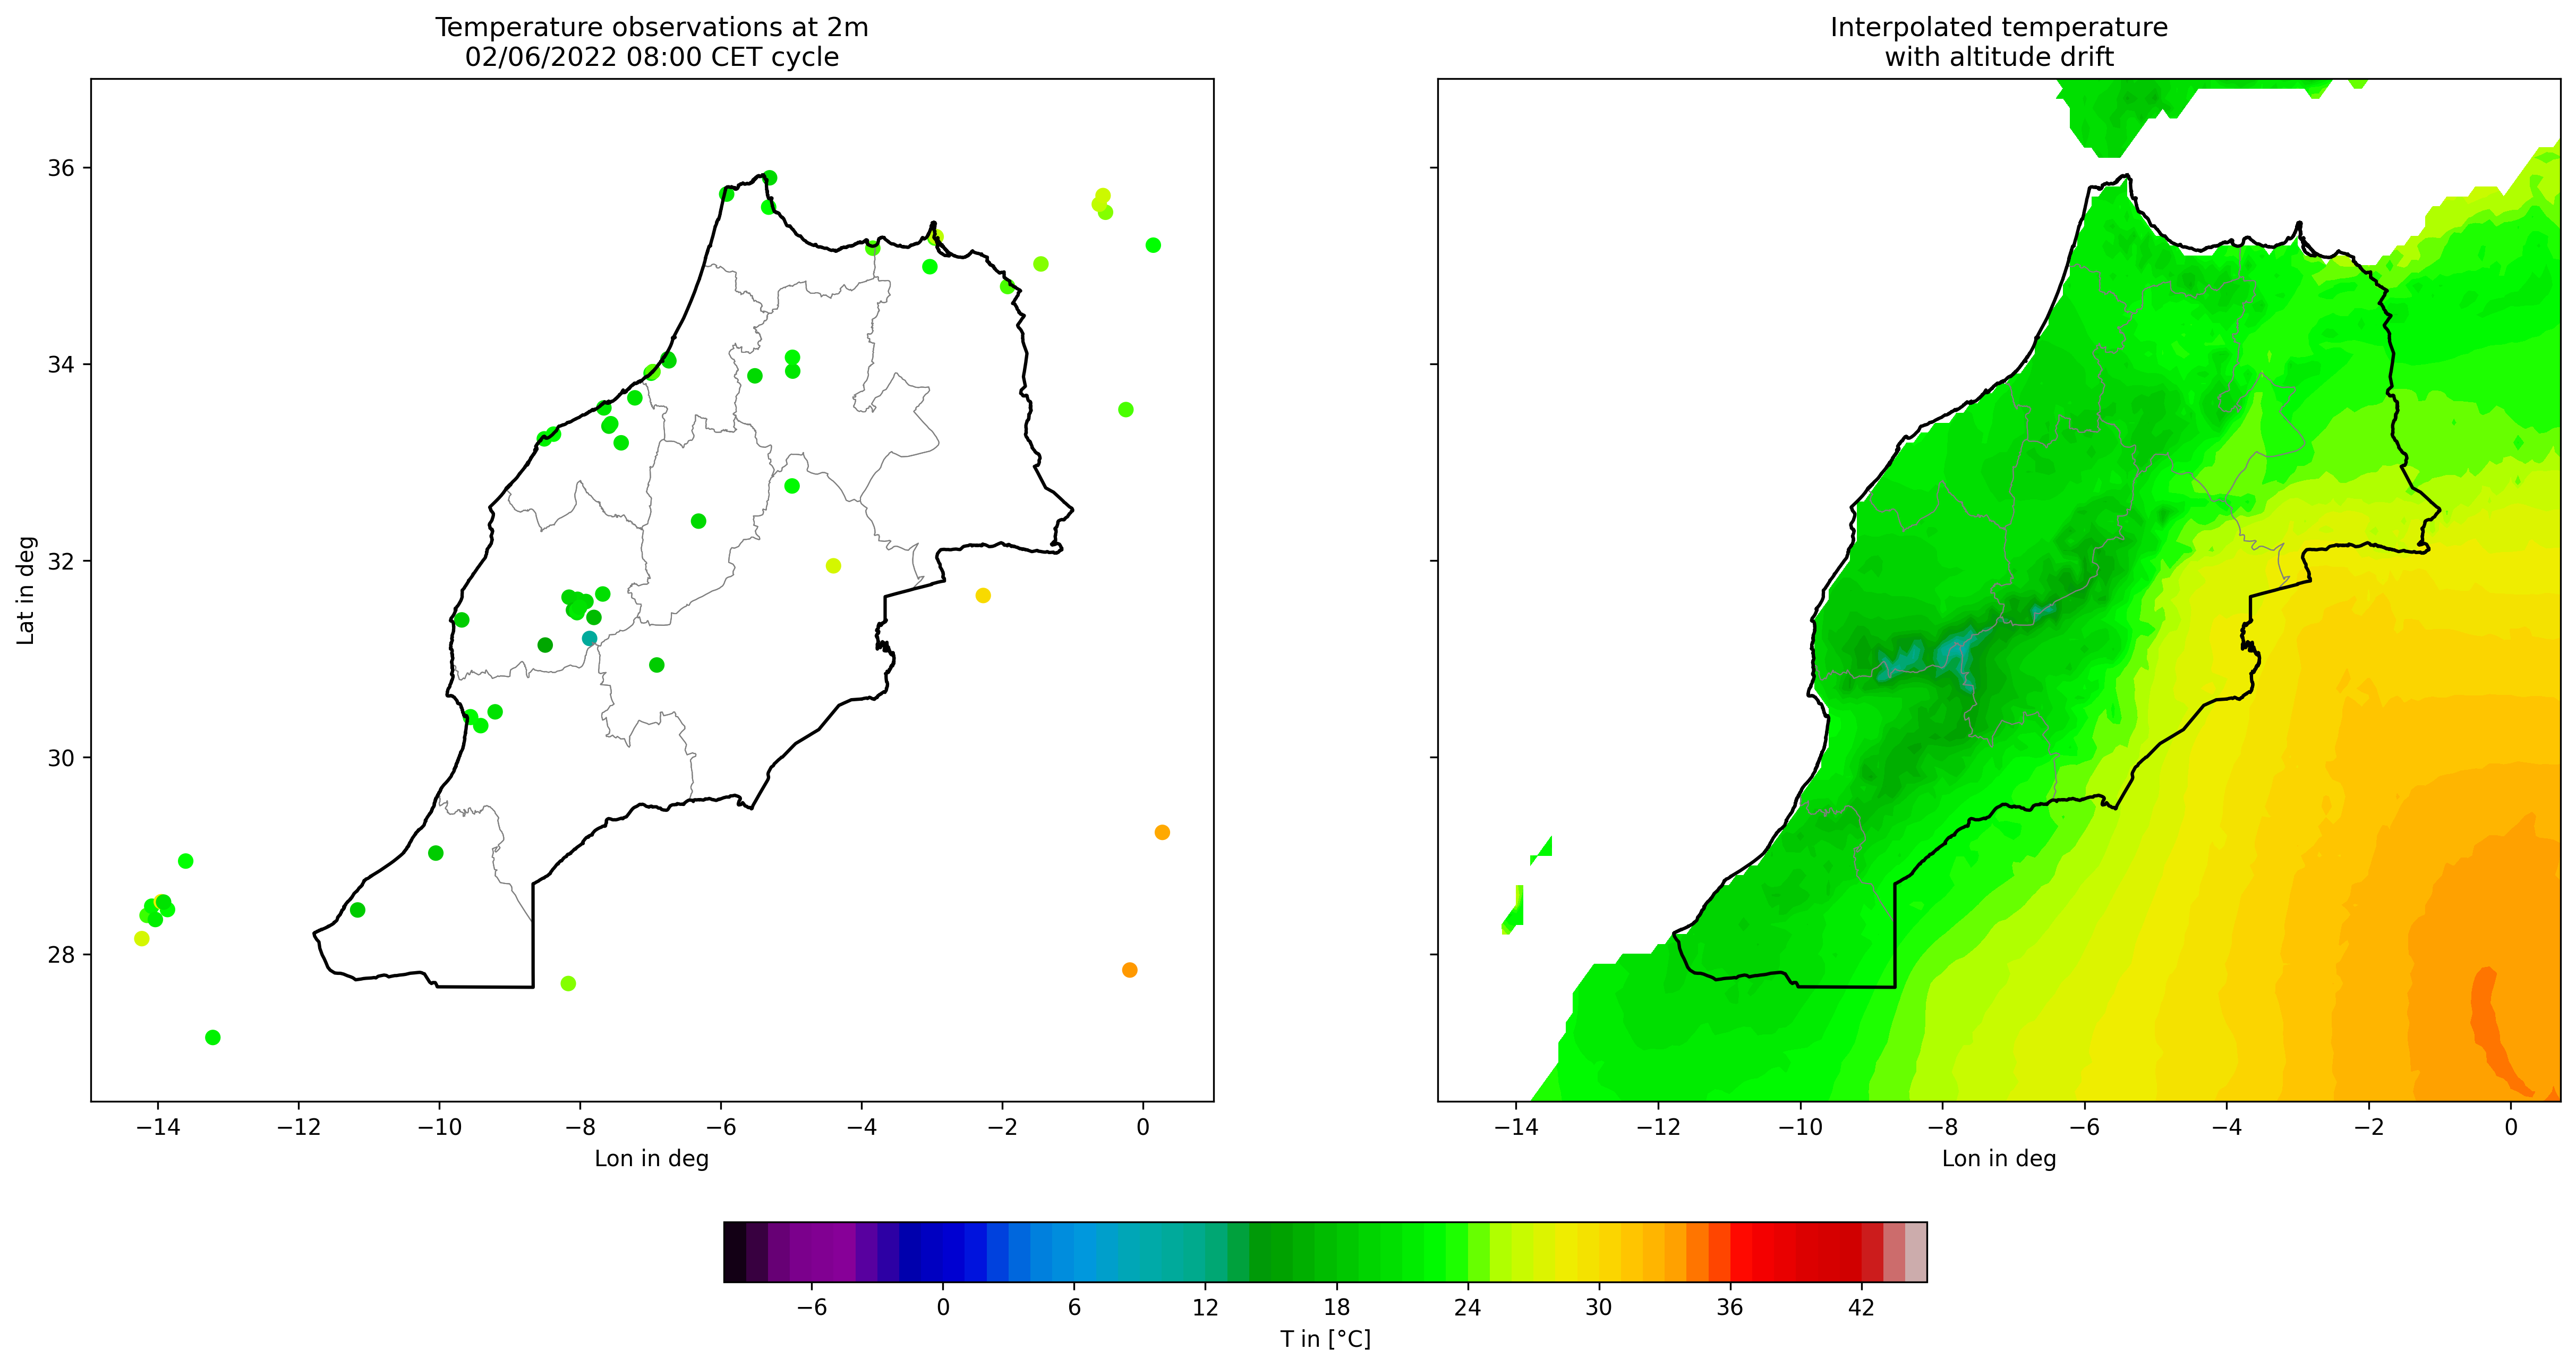

In [99]:
# plotting main figure

min=-10
max=45

levels = np.linspace(min, max, (max-min+1))
fig, ax = plt.subplots(1, 2, figsize=[20, 10], dpi=300, sharey=True)
sca = ax[0].scatter(gdf_measures_cycle["longitude_deg"], gdf_measures_cycle["latitude_deg"], c=gdf_measures_cycle["temp"], vmin=min, vmax=max, cmap="nipy_spectral")
co1 = ax[1].contourf(g_lon, g_lat, np.where(elev!=0,uk["temp_field"],np.nan), levels, cmap="nipy_spectral")
# co2 = ax[2].contourf(g_lon, g_lat, uk["mean_field"], levels, cmap="nipy_spectral")


df_2 = gpd.read_file("./data/mar_borders/mar_admbnda_adm1_unhcr_20201203.shp")  # only use the simplest polygon
for j in range(len(df_2)):
    border_2 = df_2["geometry"].values[j]
    np.savetxt("./data/mar_borders/mar_borders_2.txt", list(border_2.exterior.coords))
    border_2 = np.loadtxt("./data/mar_borders/mar_borders_2.txt")
    [ax[i].plot(border_2[:, 0], border_2[:, 1], color="gray", linewidth=0.5) for i in range(2)]

[ax[i].plot(border[:, 0], border[:, 1], color="k") for i in range(2)]

#[ax[i].set_xlim([5, 16]) for i in range(3)]
[ax[i].set_xlabel("Lon in deg") for i in range(2)]
ax[0].set_ylabel("Lat in deg")

ax[0].set_title("Temperature observations at 2m\n"+pd.to_datetime(df_measures_cycle.time.unique()[0]).strftime("%d/%m/%Y %H:%M CET cycle"))
ax[1].set_title("Interpolated temperature\nwith altitude drift")
# ax[2].set_title("Estimated mean drift\nfrom Universal Kriging")

fmt = dict(orientation="horizontal", shrink=0.5, fraction=0.05, pad=0.1)
fig.colorbar(co1, ax=ax, **fmt).set_label("T in [°C]")
plt.savefig("Morocco_"+pd.to_datetime(df_measures_cycle.time.unique()[0]).strftime("%d-%m-%Y_%H:%M_CET_cycle")+".jpg", dpi=300)

# code snippets

In [45]:
xxx

NameError: name 'xxx' is not defined

In [ ]:
# https://github.com/Jorl17/open-elevation/blob/master/docs/api.md

import json
from tqdm import tqdm

gdf_measures_cycle["elevation"]=np.nan

for i in tqdm(range(len(gdf_measures_cycle))):
    response = requests.get("https://api.open-elevation.com/api/v1/lookup?locations="+str(gdf_measures_cycle["latitude_deg"].iloc[i])+","+str(gdf_measures_cycle["longitude_deg"].iloc[i])).text
    response_info = json.loads(response)
    gdf_measures_cycle["elevation"].iloc[i] = response_info["results"][0]["elevation"]


  0%|          | 0/72 [00:00<?, ?it/s]/tmp/ipykernel_693/1399882134.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 72/72 [00:15<00:00,  4.55it/s]


## Universal + drift 1

In [ ]:
import gstools as gs

# estimating variogram

bin_center, gamma = gs.vario_estimate((gdf_measures_cycle["longitude_deg"], gdf_measures_cycle["latitude_deg"]), gdf_measures_cycle["temp"])
# fit the variogram with a stable model. (no nugget fitted)
fit_model = gs.Stable(dim=2)
fit_model.fit_variogram(bin_center, gamma, nugget=False)
# output
ax = fit_model.plot(x_max=max(bin_center))
ax.scatter(bin_center, gamma)
print(fit_model)

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

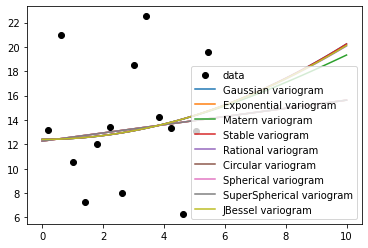

In [ ]:
bins = np.arange(40)
bin_center, gamma = gs.vario_estimate((gdf_measures_cycle["longitude_deg"], gdf_measures_cycle["latitude_deg"]), gdf_measures_cycle["temp"])

models = {
    "Gaussian": gs.Gaussian,
    "Exponential": gs.Exponential,
    "Matern": gs.Matern,
    "Stable": gs.Stable,
    "Rational": gs.Rational,
    "Circular": gs.Circular,
    "Spherical": gs.Spherical,
    "SuperSpherical": gs.SuperSpherical,
    "JBessel": gs.JBessel,
}
scores = {}

# plot the estimated variogram
plt.scatter(bin_center, gamma, color="k", label="data")
ax = plt.gca()

# fit all models to the estimated variogram
for model in models:
    fit_model = models[model](dim=2)
    para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True)
    fit_model.plot(x_max=10, ax=ax)
    scores[model] = r2

In [ ]:
ranking = sorted(scores.items(), key=lambda item: item[1], reverse=True)
print("RANKING by Pseudo-r2 score")
for i, (model, score) in enumerate(ranking, 1):
    print(f"{i:>6}. {model:>15}: {score:.5}")

plt.show()

RANKING by Pseudo-r2 score
     1.        Gaussian: 0.00043523
     2.          Stable: 0.00043458
     3.         JBessel: 0.00040694
     4.        Rational: 0.00039605
     5.          Matern: 0.00019916
     6.       Spherical: -0.0058689
     7.        Circular: -0.005869
     8.  SuperSpherical: -0.0058694
     9.     Exponential: -0.005871


## nniversal + drift including latlon

Spherical(latlon=True, var=8.02, len_scale=1.44e+03, nugget=9.3, rescale=6.37e+03)


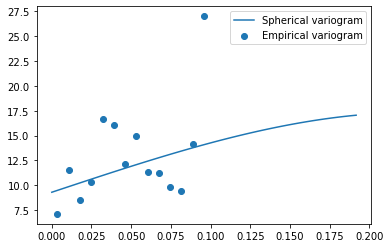

In [ ]:
emp_v = gs.vario_estimate((gdf_measures_cycle["longitude_deg"], gdf_measures_cycle["latitude_deg"]), gdf_measures_cycle["temp"], latlon=True)
sph = gs.Spherical(latlon=True, rescale=gs.EARTH_RADIUS)
sph.fit_variogram(*emp_v, sill=np.var(gdf_measures_cycle["temp"]))
ax = sph.plot(x_max=2 * np.max(emp_v[0]))
ax.scatter(*emp_v, label="Empirical variogram")
ax.legend()
print(sph)

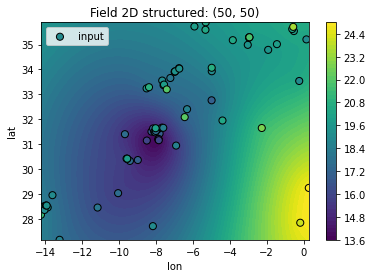

In [ ]:
# enclosing box for data points
grid_lon = np.linspace(np.min(gdf_measures_cycle["longitude_deg"]), np.max(gdf_measures_cycle["longitude_deg"]))
grid_lat = np.linspace(np.min(gdf_measures_cycle["latitude_deg"]), np.max(gdf_measures_cycle["latitude_deg"]))
# ordinary kriging
krige = gs.krige.Ordinary(sph, (gdf_measures_cycle["latitude_deg"], gdf_measures_cycle["longitude_deg"]), gdf_measures_cycle["temp"])
krige((grid_lat, grid_lon), mesh_type="structured")
ax = krige.plot()
# plotting lat on y-axis and lon on x-axis
ax.scatter(gdf_measures_cycle["longitude_deg"], gdf_measures_cycle["latitude_deg"], 50, c= gdf_measures_cycle["temp"], edgecolors="k", label="input")
ax.legend()

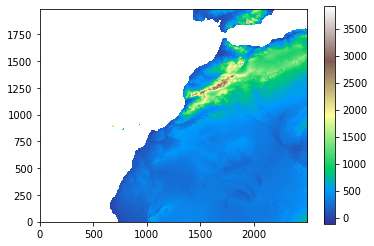

In [ ]:
plt.imshow(np.where(np.flip(z,axis=0)==0,np.nan,np.flip(z,axis=0)), cmap="terrain", origin="lower")
plt.colorbar()